In [1]:
import os
from datetime import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.7.0
keras version 2.7.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


COLUMNS:
- Open Time: Candle Open Time
- Open Price: Open Price in Quote (Secondary) Asset (USDT in the DF below)
- High Price: High Price in Quote (Secondary) Asset (USDT in the DF below)
- Low Price: Low Price in Quote (Secondary) Asset (USDT in the DF below)
- Close Price: Close Price in Quote (Secondary) Asset (USDT in the DF below)
- Volume Traded: Total Trade Volume in Primary (Base) Asset Units (BTC in the DF below)
- Close Time: Candle Close Time
- Quote Asset Volume: Total Trade Volume in Quote (Secondary) Asset Units (USDT in the DF below)
- Number of Trades: Total Number of Trades
- Taker Buy Base Asset Volume: Number of Trades in Primary (Base) Asset Resulting from a Taker Matching an Existing Order. In other words, it separates the 'Volume Traded Feature' by the amount traded as a result of orders baing placed in the order book and orders being matched in the order book (might need to revisit this, could provide additional interesting insights, if we have a better understanding of trading strategies). Volume Traded = Taker Buy Base Asset Volume + Maker Buy Base Asset Volume
- Taker Buy Quote Asset Volume: Number of Trades in Quote (Secondary) Asset Resulting from a Taker Mathcing an Existing Order. Explanation similar to the above, only difference the volume is calculated in Quote (Secondary) Asset units. Quote Asset Volume = Takes Buy Quote Asser Volume + Maker Buy Quote Asset Volume
- NA: Safe to Ignore

# Multi-Input, Single-Output LSTM on the Raw Standardized Dataset

In [4]:
# Tale's location in Drive
df = pd.read_csv('/content/gdrive/MyDrive/playground/btcusdt_data.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df['Previous Close Price'] = df['Close Price'].shift(1).values

In [6]:
df.head()

,Open Time,Open Price,High price,Low Price,Close Price,Volume Traded,Close Time,Quote asset Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume,NA,Previous Close Price
0,1502942400000,4261.48,4261.48,4261.48,4261.48,1.775183,1502942459999,7564.906851,3,0.075183,320.390851,7960.540180,NaN
1,1502942460000,4261.48,4261.48,4261.48,4261.48,0.000000,1502942519999,0.000000,0,0.000000,0.000000,7960.452630,4261.48
2,1502942520000,4280.56,4280.56,4280.56,4280.56,0.261074,1502942579999,1117.542921,2,0.261074,1117.542921,7960.375295,4261.48
3,1502942580000,4261.48,4261.48,4261.48,4261.48,0.012008,1502942639999,51.171852,3,0.012008,51.171852,7960.375295,4280.56
4,1502942640000,4261.48,4261.48,4261.48,4261.48,0.140796,1502942699999,599.999338,1,0.140796,599.999338,7960.375295,4261.48


In [7]:
df = df[1:]

In [8]:
df = df.drop(['Open Time', 'Close Time', 'NA'], axis = 1)

In [9]:
mmean = df.mean()
sstd = df.std()
df = (df - mmean) / sstd

In [10]:
input_features = ['Open Price', 'High price', 'Low Price', 'Volume Traded',
       'Quote asset Volume', 'Number of Trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Previous Close Price']

In [83]:
# TO GENERATE INPUTS
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-seq_len, seq_len, len(feats)))
  dfvs = data[feats].values
  for i in range(seq_len, len(data)):
    x = np.expand_dims(dfvs[i-seq_len:i, :], axis = 0)
    empty_np_array[i-seq_len] = x
    # print(i)
    # print(x)
    # print('---')
  return empty_np_array

In [84]:
x_train_val = generate_sequences_new(data = df, target_min = 1, seq_len = 32, feats= input_features)

In [85]:
x_train_val.shape

(2188571, 32, 9)

In [86]:
# TO GENERATE INPUTS
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-seq_len, 1, len(feats)))
  dfvs = data[feats].values
  for i in range(seq_len, len(data)):
    x = np.expand_dims(dfvs[i, :], axis = 0)
    empty_np_array[i-seq_len] = x
    # print(i)
    # print(x)
    # print('---')
  return empty_np_array

In [87]:
y_train_val = generate_sequences_new(data = df, target_min = 1, seq_len = 32, feats= ['Close Price'])

In [88]:
y_train_val.shape

(2188571, 1, 1)

In [89]:
x_train = x_train_val[:int(0.9*len(x_train_val))]
y_train = y_train_val[:int(0.9*len(x_train_val))]

x_val = x_train_val[int(0.9*len(x_train_val)):len(x_train_val)]
y_val = y_train_val[int(0.9*len(x_train_val)):len(x_train_val)]

In [90]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1969713, 32, 9), (1969713, 1, 1), (218858, 32, 9), (218858, 1, 1))

In [93]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [94]:
MAX_EPOCHS = 5

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

In [95]:
history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

Epoch 1/5
61554/61554 [==============================] - 234s 4ms/step - loss: 1.0828e-04 - mean_absolute_error: 0.0034 - val_loss: 2.7399e-05 - val_mean_absolute_error: 0.0032
Epoch 2/5
61554/61554 [==============================] - 232s 4ms/step - loss: 1.8126e-05 - mean_absolute_error: 0.0021 - val_loss: 4.4924e-05 - val_mean_absolute_error: 0.0033
Epoch 3/5
61554/61554 [==============================] - 229s 4ms/step - loss: 1.3586e-05 - mean_absolute_error: 0.0019 - val_loss: 2.5197e-05 - val_mean_absolute_error: 0.0030
Epoch 4/5
61554/61554 [==============================] - 229s 4ms/step - loss: 1.1855e-05 - mean_absolute_error: 0.0017 - val_loss: 1.4971e-04 - val_mean_absolute_error: 0.0066
Epoch 5/5
61554/61554 [==============================] - 228s 4ms/step - loss: 1.0474e-05 - mean_absolute_error: 0.0017 - val_loss: 9.1503e-05 - val_mean_absolute_error: 0.0044


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18944     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


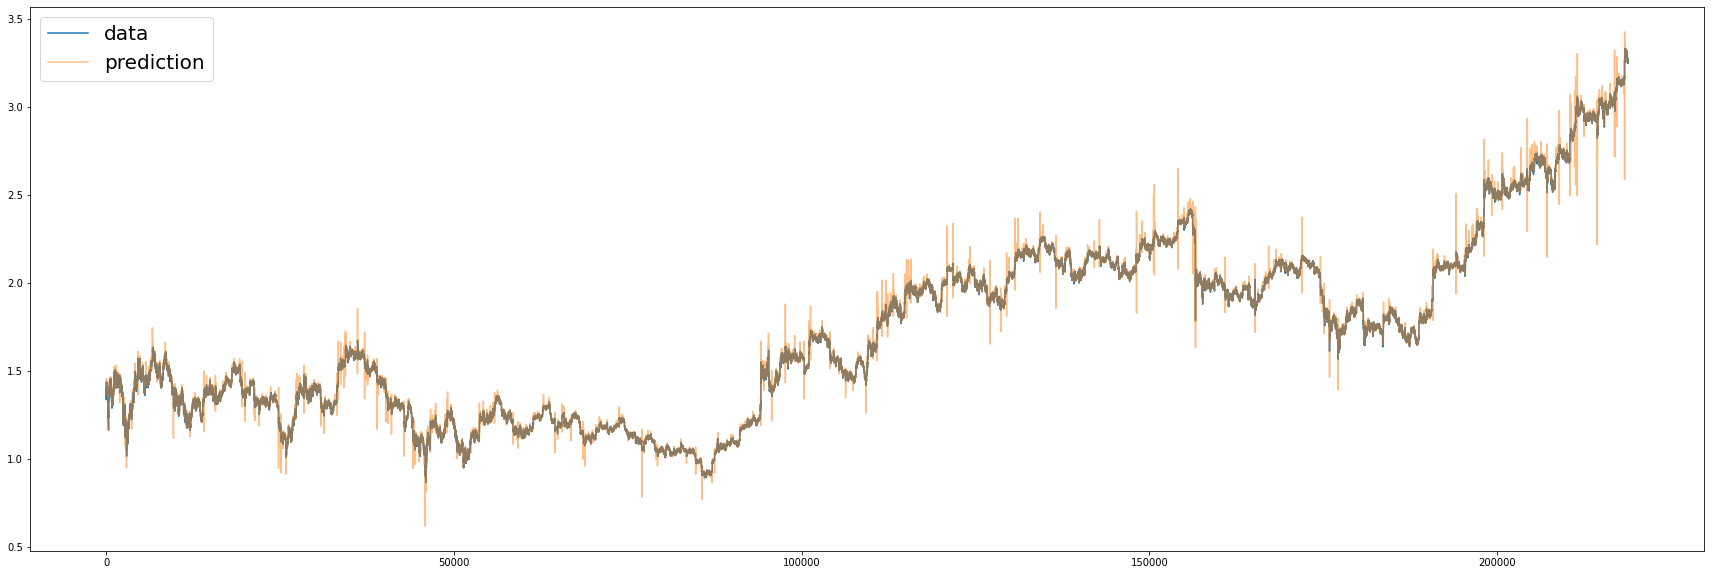

In [96]:
lstm_model2.summary()
val_pred2 = lstm_model2.predict(x_val)
y_vals = [yi[-1] for yi in y_val]
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(y_vals, label = 'data')
ax.plot(val_pred2, alpha = 0.5, label = 'prediction')
ax.legend(loc = 'best', fontsize = 20)

# Baseline Model on Raw Standardized Data

In [32]:
baseline_df = df[32:]
baseline_df_train = baseline_df[:int(0.9*len(baseline_df))]
baseline_df_val = baseline_df[int(0.9*len(baseline_df)):len(baseline_df)]

In [34]:
print(mean_squared_error(baseline_df_train['Close Price'].values, baseline_df_train['Previous Close Price'].values))

2.8378137385132154e-06


In [55]:
train_mse = mean_squared_error(baseline_df_train['Close Price'].values, baseline_df_train['Previous Close Price'].values)
validation_mse = mean_squared_error(baseline_df_val['Close Price'].values, baseline_df_val['Previous Close Price'].values)
train_mae = mean_absolute_error(baseline_df_train['Close Price'].values, baseline_df_train['Previous Close Price'].values)
validation_mae = mean_absolute_error(baseline_df_val['Close Price'].values, baseline_df_val['Previous Close Price'].values)

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f"The MSE of the baseline model on the training dataset is: {train_mse}")
print(f'The MSE of the baseline model on the validation dataset is: {validation_mse}')

print(f'The MAE of the baseline model on the training dataset is: {train_mae:.6f}')
print(f'The MAE of the baseline model on the validation dataset is: {validation_mae:.6f}')

The MSE of the baseline model on the training dataset is: 2.8378137385132154e-06
The MSE of the baseline model on the validation dataset is: 9.223536144798333e-06
The MAE of the baseline model on the training dataset is: 0.000697
The MAE of the baseline model on the validation dataset is: 0.002004


# Multi-Input, Multi-Output LSTM on Raw Standardized Dataset

In [20]:
# TO GENERATE INPUTS
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-2*seq_len+1, seq_len, len(feats)))
  dfvs = data[feats].values
  for i in range(seq_len, len(data)-seq_len+1):
    x = np.expand_dims(dfvs[i-seq_len:i, :], axis = 0)
    empty_np_array[i-seq_len] = x
  return empty_np_array

In [21]:
x_train_val = generate_sequences_new(data = df, target_min = 1, seq_len = 32, feats= input_features)

In [22]:
x_train_val.shape

(2188540, 32, 9)

In [23]:
# TO GENERATE OUTPUTS
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-2*seq_len+1, seq_len, len(feats)))
  dfvs = data[feats].values
  for i in range(seq_len, len(data)-seq_len+1):
    x = np.expand_dims(dfvs[i:i+seq_len, :], axis = 0)
    empty_np_array[i-seq_len] = x
  return empty_np_array

In [24]:
y_train_val = generate_sequences_new(data = df, target_min = 1, seq_len = 32, feats= ['Close Price'])

In [25]:
y_train_val.shape

(2188540, 32, 1)

In [26]:
x_train = x_train_val[:int(0.9*len(x_train_val))]
y_train = y_train_val[:int(0.9*len(x_train_val))]

x_val = x_train_val[int(0.9*len(x_train_val)):len(x_train_val)]
y_val = y_train_val[int(0.9*len(x_train_val)):len(x_train_val)]

In [27]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1969686, 32, 9), (1969686, 32, 1), (218854, 32, 9), (218854, 32, 1))

In [28]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=32)
])

In [29]:
MAX_EPOCHS = 5

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

In [30]:
history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

Epoch 1/5
61553/61553 [==============================] - 234s 4ms/step - loss: 3.6261e-04 - mean_absolute_error: 0.0056 - val_loss: 2.1984e-04 - val_mean_absolute_error: 0.0100
Epoch 2/5
61553/61553 [==============================] - 229s 4ms/step - loss: 6.5981e-05 - mean_absolute_error: 0.0041 - val_loss: 2.0512e-04 - val_mean_absolute_error: 0.0096
Epoch 3/5
61553/61553 [==============================] - 228s 4ms/step - loss: 5.9723e-05 - mean_absolute_error: 0.0037 - val_loss: 2.5132e-04 - val_mean_absolute_error: 0.0098
Epoch 4/5
61553/61553 [==============================] - 228s 4ms/step - loss: 5.7135e-05 - mean_absolute_error: 0.0036 - val_loss: 2.1095e-04 - val_mean_absolute_error: 0.0100
Epoch 5/5
61553/61553 [==============================] - 229s 4ms/step - loss: 5.4911e-05 - mean_absolute_error: 0.0035 - val_loss: 1.6730e-04 - val_mean_absolute_error: 0.0084


# Countless Models and Preprocessing Steps Tested (SAFE TO IGNORE!)

In [ ]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [ ]:
batch_size = 1024
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

print('train_data',train_data)
print('validation_data',validation_data)

In [ ]:
# single = train_data.take(1)

In [ ]:
# for s in single:
#   print(s[0].shape, s[1].shape)
#   print(s[0][0])

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=32)
])

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, train_data, validation_data, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(train_data, epochs=MAX_EPOCHS, validation_data = validation_data)
  return history

In [ ]:
history2 = compile_and_fit(lstm_model2, train_data, validation_data)

In [ ]:
# Modelling on the Standardizer Dataset

from numpy import load
x_train = load('/content/gdrive/MyDrive/playground/x_train_simple.npy')
y_train = load('/content/gdrive/MyDrive/playground/y_train_simple.npy')
x_val = load('/content/gdrive/MyDrive/playground/x_val_simple.npy')
y_val = load('/content/gdrive/MyDrive/playground/y_val_simple.npy')

x_train.shape, y_train.shape, x_val.shape, y_val.shape

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(64)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)

# Simple RNN Model
model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# first weights for the input, second weights for the hidden state, third weights for bias
model.layers[0].get_weights()[0].shape, model.layers[0].get_weights()[1].shape, model.layers[0].get_weights()[2].shape

weights_h = np.zeros((64,64))
weights_b = np.zeros((64,))
weights_h.shape, weights_b.shape

model.layers[0].set_weights([model.layers[0].get_weights()[0], weights_h, weights_b])
model.layers[0].get_weights()[2]
model.layers[0].trainable = False

MAX_EPOCHS = 2

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

history2 = compile_and_fit(model, x_train, y_train, x_val, y_val)

model.summary()
val_pred2 = model.predict(x_val)
y_vals = [yi[-1] for yi in y_val]
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(y_vals, label = 'data')
ax.plot(val_pred2, alpha = 0.5, label = 'prediction')
ax.legend(loc = 'best', fontsize = 20)

# LSTM Model
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

from tensorflow.keras.regularizers import L1L2

def make_reg_LSTM():
  reg = L1L2(l1=0.0, l2=0.01)

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.LSTM(200, kernel_regularizer=reg, return_sequences=True))
  # model.add(tf.keras.layers.LSTM(200, activation='tanh', input_shape=(win_length, num_features), kernel_regularizer=reg, return_sequences=True))
  
  model.add(tf.keras.layers.Dropout(0.01))

  model.add(tf.keras.layers.Dense(100, activation='relu'))

  model.add(tf.keras.layers.LSTM(100, activation='tanh', return_sequences=False))
  model.add(tf.keras.layers.Dropout(0.01))
  
  model.add(tf.keras.layers.Dense(50, activation='relu'))
  
  model.add(tf.keras.layers.Dense(1))

  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
  model.compile(loss=tf.keras.losses.MeanSquaredError(), # Huber is less sensitive to outliers
                          optimizer=optimizer,
                          metrics=["mae"])

  
  #model.summary()

  return model

lstm_model2 = make_reg_LSTM()

MAX_EPOCHS = 5
history = lstm_model2.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))

MAX_EPOCHS = 5

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.SGD(learning_rate=2e-3, momentum=0.9),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

lstm_model2.summary()
val_pred2 = lstm_model2.predict(x_val)
y_vals = [yi[-1] for yi in y_val]
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(y_vals, label = 'data')
ax.plot(val_pred2, alpha = 0.5, label = 'prediction')
ax.legend(loc = 'best', fontsize = 20)

lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 5

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

# Preprocessing ends here

In [ ]:
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-seq_len+1, seq_len, len(feats)))
  dfvs = data[feats].values
  print(len(data)-seq_len+1)
  for i in range(1, len(data)-seq_len+1):
    x = np.expand_dims(dfvs[i:i+seq_len, :], axis = 0)
    print(x.shape, i)
    empty_np_array[i] = x
  return empty_np_array

In [ ]:
y_train_val = generate_sequences_new(data = test_df, target_min = 1, seq_len = 10, feats= ['Close Price'])


In [ ]:
test_df.tail(10)

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
df.values[:,3]

In [ ]:
train_data = multivariate_data(df.values, df.values[:,3], 0, 100, 32, 1, 1, single_step = True)

In [ ]:
train_data[0].shape, train_data[1].shape

In [ ]:
for idx in range(1, 32):
  df['Close Price' + str(idx)] = df['Close Price'].shift(-idx).values

In [ ]:
df.head()

In [ ]:
df = df[:-31]

In [ ]:
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-seq_len+1, seq_len, len(feats)))
  dfvs = data[feats].values
  for i in range(len(data)-seq_len+1):
    x = np.expand_dims(dfvs[i:i+seq_len, :], axis = 0)
    print(x.shape)
    empty_np_array[i] = x
  return empty_np_array

In [ ]:
empty_np_array = np.zeros((len(data)-seq_len+1, seq_len))
dfvs = data['Close Price'].values
for i in range(len(data)-seq_len+1):
  x = 

In [ ]:
train_val_data = df[:int(n*0.01)]
x_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= predict_features)
y_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= output_features)


In [ ]:
mmean = df.mean()
sstd = df.std()
df = (df - mmean) / sstd

In [ ]:
df.columns

In [ ]:
win_length = 32
# just so it runs faster for Connor
# n = len(df)*0.0001
n = len(df)*0.01
train_val_data = df[:int(n*0.9)]
test_data = df[int(n*0.9):int(n)]
predict_features = ['Open Price', 'High price', 'Low Price', 'Volume Traded',
       'Quote asset Volume', 'Number of Trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume']
output_features = ['Close Price', 'Close Price1', 'Close Price2',
       'Close Price3', 'Close Price4', 'Close Price5', 'Close Price6',
       'Close Price7', 'Close Price8', 'Close Price9', 'Close Price10',
       'Close Price11', 'Close Price12', 'Close Price13', 'Close Price14',
       'Close Price15', 'Close Price16', 'Close Price17', 'Close Price18',
       'Close Price19', 'Close Price20', 'Close Price21', 'Close Price22',
       'Close Price23', 'Close Price24', 'Close Price25', 'Close Price26',
       'Close Price27', 'Close Price28', 'Close Price29', 'Close Price30',
       'Close Price31']

In [ ]:
# this is incorporating both training and validation sets
x_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= predict_features)
print(x_train_val.shape)

y_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= output_features)
print(y_train_val.shape)

x_test = generate_sequences_new(data = test_data, target_min = 1, seq_len = win_length,feats= predict_features)
print(x_test.shape)

In [ ]:
# this is separating into training and validation sets
x_train = x_train_val[:int(0.9*len(x_train_val))]
y_train = y_train_val[:int(0.9*len(x_train_val))]

x_val = x_train_val[int(0.9*len(x_train_val)):len(x_train_val)]
y_val = y_train_val[int(0.9*len(x_train_val)):len(x_train_val)]

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=32)
])

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

In [ ]:
history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

In [ ]:
lstm_model2.summary()

In [ ]:
val_pred2 = lstm_model2.predict(x_val)
y_vals = [yi[-1] for yi in y_val]
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(y_vals, label = 'data')
ax.plot(val_pred2, alpha = 0.5, label = 'prediction')
ax.legend(loc = 'best', fontsize = 20)

- Training on the whole dataset

In [ ]:
win_length = 32

n = len(df)
train_val_data = df[:int(n*0.975)]
test_data = df[int(n*0.975):int(n)]
predict_features = ['Open Price', 'High price', 'Low Price', 'Volume Traded',
       'Quote asset Volume', 'Number of Trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume']

In [ ]:
# this is incorporating both training and validation sets
x_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= predict_features)
print(x_train_val.shape)

y_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= ['Close Price'])
print(y_train_val.shape)

x_test = generate_sequences_new(data = test_data, target_min = 1, seq_len = win_length,feats= predict_features)
print(x_test.shape)

In [ ]:
# this is separating into training and validation sets
x_train = x_train_val[:int(0.95*len(x_train_val))]
y_train = y_train_val[:int(0.95*len(x_train_val))]

x_val = x_train_val[int(0.95*len(x_train_val)):len(x_train_val)]
y_val = y_train_val[int(0.95*len(x_train_val)):len(x_train_val)]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(64)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(train_dataset, epochs=MAX_EPOCHS, validation_data = validation_dataset)
  return history

In [ ]:
history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

In [ ]:
val_pred2 = lstm_model2.predict(x_val)
y_vals = [yi[-1] for yi in y_val]
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(y_vals, label = 'data')
ax.plot(val_pred2, alpha = 0.5, label = 'prediction')
ax.legend(loc = 'best', fontsize = 20)

# Feature Engineering Starts Here - With Log-Transformations

In [ ]:
# Tale's location in Drive
btcusdt_df = pd.read_csv('/content/gdrive/MyDrive/playground/btcusdt_data.csv', index_col=0)

In [ ]:
display(btcusdt_df.head())

In [ ]:
def time_features_func(btcusdt_df = btcusdt_df):
  btcusdt_df['Date'] = pd.to_datetime(btcusdt_df['Open Time'], unit = 'ms')
  btcusdt_df['Year'] = pd.DatetimeIndex(btcusdt_df['Date']).year
  btcusdt_df['Month'] = pd.DatetimeIndex(btcusdt_df['Date']).month
  btcusdt_df['Day of Week'] = pd.DatetimeIndex(btcusdt_df['Date']).dayofweek
  btcusdt_df['Day of Month'] = pd.DatetimeIndex(btcusdt_df['Date']).day
  btcusdt_df['Day of Year'] = pd.DatetimeIndex(btcusdt_df['Date']).dayofyear
  btcusdt_df['Week of Month'] = pd.DatetimeIndex(btcusdt_df['Date']).day // 7
  btcusdt_df['Week of Year'] = btcusdt_df['Date'].dt.isocalendar().week
  return btcusdt_df

In [ ]:
btcusdt_df = time_features_func()

In [ ]:
from functools import reduce

def stat_features_func(btcusdt_df = btcusdt_df):
  col_names = ['Open Price', 'High price', 'Low Price', 'Close Price', 'Volume Traded', 'Quote asset Volume']
  for col in col_names:
    print(col)
    df_mean = pd.DataFrame(np.log(btcusdt_df[col].rolling(window = 64, min_periods = 1).mean() + 1)).rename(columns={col: f'{col} Mean'})
    df_min = pd.DataFrame(np.log(btcusdt_df[col].rolling(window = 64, min_periods = 1).min() + 1)).rename(columns={col: f'{col} Min'})
    df_max = pd.DataFrame(np.log(btcusdt_df[col].rolling(window = 64, min_periods = 1).max() + 1)).rename(columns={col: f'{col} Max'})
    df_std = pd.DataFrame(np.log(btcusdt_df[col].rolling(window = 64, min_periods = 1).std() + 1)).rename(columns={col: f'{col} Std'})
    df_q25 = pd.DataFrame(np.log(btcusdt_df[col].rolling(window = 64, min_periods = 1).quantile(0.25) + 1)).rename(columns={col: f'{col} 25Q'})
    df_q50 = pd.DataFrame(np.log(btcusdt_df[col].rolling(window = 64, min_periods = 1).quantile(0.50) + 1)).rename(columns={col: f'{col} 50Q'})
    df_q75 = pd.DataFrame(np.log(btcusdt_df[col].rolling(window = 64, min_periods = 1).quantile(0.75) + 1)).rename(columns={col: f'{col} 75Q'})

    df_mean.loc[df_mean[f'{col} Mean'].head(64).index, f'{col} Mean'] = np.NaN
    df_min.loc[df_min[f'{col} Min'].head(64).index, f'{col} Min'] = np.NaN
    df_max.loc[df_max[f'{col} Max'].head(64).index, f'{col} Max'] = np.NaN
    df_std.loc[df_std[f'{col} Std'].head(64).index, f'{col} Std'] = np.NaN
    df_q25.loc[df_q25[f'{col} 25Q'].head(64).index, f'{col} 25Q'] = np.NaN
    df_q50.loc[df_q50[f'{col} 50Q'].head(64).index, f'{col} 50Q'] = np.NaN
    df_q75.loc[df_q75[f'{col} 75Q'].head(64).index, f'{col} 75Q'] = np.NaN

    df_list = [btcusdt_df, df_mean, df_min, df_max, df_std, df_q25, df_q50, df_q75]
    btcusdt_df = reduce(lambda l, r: pd.merge(l, r, how = 'outer', left_index=True, right_index=True, validate='one_to_one'), df_list)
  return btcusdt_df

In [ ]:
btcusdt_df = stat_features_func()

In [ ]:
def nminutes_predc_func(btcusdt_df = btcusdt_df):
  # add the maturity of the coins: nulber of minutes since creation
  btcusdt_df['Number Minutes Creation'] = np.log(btcusdt_df.index.values + 1)
  # previous close
  btcusdt_df['Previous Close Price'] = np.log(btcusdt_df['Close Price'].shift(1).values + 1)
  return btcusdt_df

In [ ]:
btcusdt_df = nminutes_predc_func()

In [ ]:
def trend_func(btcusdt_df = btcusdt_df):
  # the liquidity of the pair - moving averge over the last 30 days to divide the volume
  df_mean = pd.DataFrame(btcusdt_df['Volume Traded'].rolling(window = 43200, min_periods = 1).mean()).rename(columns={'Volume Traded': 'Mean Volume Traded'})
  btcusdt_df['Volume Traded/Mean Volume Traded'] = np.log((btcusdt_df['Volume Traded'].values/df_mean['Mean Volume Traded'].values) + 1)
  btcusdt_df.loc[btcusdt_df['Volume Traded/Mean Volume Traded'].head(43200).index, 'Volume Traded/Mean Volume Traded'] = np.NaN
  return btcusdt_df

In [ ]:
btcusdt_df = trend_func()

In [ ]:
columns = ['Open Price', 'High price', 'Low Price', 'Volume Traded', 'Quote asset Volume', 'Number of Trades', 'Taker buy base asset volume', 'Taker buy quote asset volume']
for col in columns:
  btcusdt_df[col] = np.log(btcusdt_df[col].values + 1)

In [ ]:
columns = ['Year', 'Month', 'Day of Week', 'Day of Month', 'Day of Year', 'Week of Month', 'Week of Year']
for col in columns:
  btcusdt_df[col] = np.log(btcusdt_df[col].values + 1)

In [ ]:
btcusdt_df.isna().sum()

In [ ]:
btcusdt_df = btcusdt_df[43200:]

In [ ]:
df = btcusdt_df.copy()

# Feature Engineering Ends Here - With Log-Transformations

# Modeling on 2021 Data, Log-Transformed Data

In [ ]:
df.head()

In [ ]:
df['Date_new'] = pd.to_datetime(df['Open Time'], unit = 'ms')
df['Year_new'] = pd.DatetimeIndex(df['Date_new']).year

In [ ]:
df = df.loc[df['Year_new'] == 2021]
df = df.reset_index(drop=True)
df.head()

In [ ]:
df = df.drop(['Date_new', 'Year_new'], axis = 1)


In [ ]:
btcusdt_df.columns

In [ ]:
df = df.drop(['Open Time', 'Close Time', 'NA', 'Date', 'Year'], axis = 1)

In [ ]:
mmean = df.mean()
sstd = df.std()
df = (df - mmean) / sstd

In [ ]:
win_length = 32

n = len(df)
train_val_data = df[:int(n*0.975)]
test_data = df[int(n*0.975):int(n)]
predict_features = ['Open Price', 'High price', 'Low Price', 'Volume Traded',
       'Quote asset Volume', 'Number of Trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Month', 'Day of Week',
       'Day of Month', 'Day of Year', 'Week of Month', 'Week of Year',
       'Open Price Mean', 'Open Price Min', 'Open Price Max', 'Open Price Std',
       'Open Price 25Q', 'Open Price 50Q', 'Open Price 75Q', 'High price Mean',
       'High price Min', 'High price Max', 'High price Std', 'High price 25Q',
       'High price 50Q', 'High price 75Q', 'Low Price Mean', 'Low Price Min',
       'Low Price Max', 'Low Price Std', 'Low Price 25Q', 'Low Price 50Q',
       'Low Price 75Q', 'Close Price Mean', 'Close Price Min',
       'Close Price Max', 'Close Price Std', 'Close Price 25Q',
       'Close Price 50Q', 'Close Price 75Q', 'Volume Traded Mean',
       'Volume Traded Min', 'Volume Traded Max', 'Volume Traded Std',
       'Volume Traded 25Q', 'Volume Traded 50Q', 'Volume Traded 75Q',
       'Quote asset Volume Mean', 'Quote asset Volume Min',
       'Quote asset Volume Max', 'Quote asset Volume Std',
       'Quote asset Volume 25Q', 'Quote asset Volume 50Q',
       'Quote asset Volume 75Q', 'Number Minutes Creation',
       'Previous Close Price', 'Volume Traded/Mean Volume Traded']

In [ ]:
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-seq_len+1, seq_len, len(feats)))
  dfvs = data[feats].values
  for i in range(len(data)-seq_len+1):
    x = np.expand_dims(dfvs[i:i+seq_len, :], axis = 0)
    empty_np_array[i] = x
  return empty_np_array

In [ ]:
# this is incorporating both training and validation sets
x_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= predict_features)
print(x_train_val.shape)

y_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= ['Close Price'])
print(y_train_val.shape)

x_test = generate_sequences_new(data = test_data, target_min = 1, seq_len = win_length,feats= predict_features)
print(x_test.shape)

In [ ]:
# this is separating into training and validation sets
x_train = x_train_val[:int(0.95*len(x_train_val))]
y_train = y_train_val[:int(0.95*len(x_train_val))]

x_val = x_train_val[int(0.95*len(x_train_val)):len(x_train_val)]
y_val = y_train_val[int(0.95*len(x_train_val)):len(x_train_val)]

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

In [ ]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(64)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 10

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.005),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

In [ ]:
history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

In [ ]:
lstm_model2.summary()
val_pred2 = lstm_model2.predict(x_val)
y_vals = [yi[-1] for yi in y_val]
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(y_vals, label = 'data')
ax.plot(val_pred2, alpha = 0.5, label = 'prediction')
ax.legend(loc = 'best', fontsize = 20)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))
ax[0].plot(history2.history['loss'], label = 'loss')
ax[0].plot(history2.history['val_loss'], label = 'val_loss')
ax[1].plot(history2.history['mean_absolute_error'], label = 'mean_absolute_error')
ax[1].plot(history2.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best');

# Feature Engineering Starts Here - No Log-Transformations

In [ ]:
# Tale's location in Drive
btcusdt_df = pd.read_csv('/content/gdrive/MyDrive/playground/btcusdt_data.csv', index_col=0)

In [ ]:
from functools import reduce

def time_features_func(btcusdt_df = btcusdt_df):
  btcusdt_df['Date'] = pd.to_datetime(btcusdt_df['Open Time'], unit = 'ms')
  btcusdt_df['Year'] = pd.DatetimeIndex(btcusdt_df['Date']).year
  btcusdt_df['Month'] = pd.DatetimeIndex(btcusdt_df['Date']).month
  btcusdt_df['Day of Week'] = pd.DatetimeIndex(btcusdt_df['Date']).dayofweek
  btcusdt_df['Day of Month'] = pd.DatetimeIndex(btcusdt_df['Date']).day
  btcusdt_df['Day of Year'] = pd.DatetimeIndex(btcusdt_df['Date']).dayofyear
  btcusdt_df['Week of Month'] = pd.DatetimeIndex(btcusdt_df['Date']).day // 7
  btcusdt_df['Week of Year'] = btcusdt_df['Date'].dt.isocalendar().week
  return btcusdt_df

def stat_features_func(btcusdt_df = btcusdt_df):
  col_names = ['Open Price', 'High price', 'Low Price', 'Close Price', 'Volume Traded', 'Quote asset Volume']
  for col in col_names:
    print(col)
    df_mean = pd.DataFrame(btcusdt_df[col].rolling(window = 64, min_periods = 1).mean()).rename(columns={col: f'{col} Mean'})
    df_min = pd.DataFrame(btcusdt_df[col].rolling(window = 64, min_periods = 1).min()).rename(columns={col: f'{col} Min'})
    df_max = pd.DataFrame(btcusdt_df[col].rolling(window = 64, min_periods = 1).max()).rename(columns={col: f'{col} Max'})
    df_std = pd.DataFrame(btcusdt_df[col].rolling(window = 64, min_periods = 1).std()).rename(columns={col: f'{col} Std'})
    df_q25 = pd.DataFrame(btcusdt_df[col].rolling(window = 64, min_periods = 1).quantile(0.25)).rename(columns={col: f'{col} 25Q'})
    df_q50 = pd.DataFrame(btcusdt_df[col].rolling(window = 64, min_periods = 1).quantile(0.50)).rename(columns={col: f'{col} 50Q'})
    df_q75 = pd.DataFrame(btcusdt_df[col].rolling(window = 64, min_periods = 1).quantile(0.75)).rename(columns={col: f'{col} 75Q'})

    df_mean.loc[df_mean[f'{col} Mean'].head(64).index, f'{col} Mean'] = np.NaN
    df_min.loc[df_min[f'{col} Min'].head(64).index, f'{col} Min'] = np.NaN
    df_max.loc[df_max[f'{col} Max'].head(64).index, f'{col} Max'] = np.NaN
    df_std.loc[df_std[f'{col} Std'].head(64).index, f'{col} Std'] = np.NaN
    df_q25.loc[df_q25[f'{col} 25Q'].head(64).index, f'{col} 25Q'] = np.NaN
    df_q50.loc[df_q50[f'{col} 50Q'].head(64).index, f'{col} 50Q'] = np.NaN
    df_q75.loc[df_q75[f'{col} 75Q'].head(64).index, f'{col} 75Q'] = np.NaN

    df_list = [btcusdt_df, df_mean, df_min, df_max, df_std, df_q25, df_q50, df_q75]
    btcusdt_df = reduce(lambda l, r: pd.merge(l, r, how = 'outer', left_index=True, right_index=True, validate='one_to_one'), df_list)
  return btcusdt_df

def nminutes_predc_func(btcusdt_df = btcusdt_df):
  # add the maturity of the coins: nulber of minutes since creation
  btcusdt_df['Number Minutes Creation'] = btcusdt_df.index.values
  # previous close
  btcusdt_df['Previous Close Price'] = btcusdt_df['Close Price'].shift(1).values
  return btcusdt_df

def trend_func(btcusdt_df = btcusdt_df):
  # the liquidity of the pair - moving averge over the last 30 days to divide the volume
  df_mean = pd.DataFrame(btcusdt_df['Volume Traded'].rolling(window = 43200, min_periods = 1).mean()).rename(columns={'Volume Traded': 'Mean Volume Traded'})
  btcusdt_df['Volume Traded/Mean Volume Traded'] = (btcusdt_df['Volume Traded'].values/df_mean['Mean Volume Traded'].values)
  btcusdt_df.loc[btcusdt_df['Volume Traded/Mean Volume Traded'].head(43200).index, 'Volume Traded/Mean Volume Traded'] = np.NaN
  return btcusdt_df


In [ ]:
btcusdt_df = time_features_func(btcusdt_df)

In [ ]:
btcusdt_df = stat_features_func(btcusdt_df)
display(btcusdt_df.shape)

In [ ]:
btcusdt_df = nminutes_predc_func(btcusdt_df)

In [ ]:
btcusdt_df = trend_func(btcusdt_df)

In [ ]:
btcusdt_df.isna().sum()

In [ ]:
btcusdt_df = btcusdt_df[43200:]
df = btcusdt_df.copy()

In [ ]:
df = df.loc[df['Year'] == 2021]
df = df.reset_index(drop=True)
df.head()

# Modeling on 2021 Data, No Log-Transformed Data

In [ ]:
df = df.drop(['Open Time', 'Close Time', 'NA', 'Date', 'Year'], axis = 1)

In [ ]:
mmean = df.mean()
sstd = df.std()
df = (df - mmean) / sstd

In [ ]:
win_length = 32

n = len(df)
train_val_data = df[:int(n*0.975)]
test_data = df[int(n*0.975):int(n)]
predict_features = ['Open Price', 'High price', 'Low Price', 'Volume Traded',
       'Quote asset Volume', 'Number of Trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Month', 'Day of Week',
       'Day of Month', 'Day of Year', 'Week of Month', 'Week of Year',
       'Open Price Mean', 'Open Price Min', 'Open Price Max', 'Open Price Std',
       'Open Price 25Q', 'Open Price 50Q', 'Open Price 75Q', 'High price Mean',
       'High price Min', 'High price Max', 'High price Std', 'High price 25Q',
       'High price 50Q', 'High price 75Q', 'Low Price Mean', 'Low Price Min',
       'Low Price Max', 'Low Price Std', 'Low Price 25Q', 'Low Price 50Q',
       'Low Price 75Q', 'Close Price Mean', 'Close Price Min',
       'Close Price Max', 'Close Price Std', 'Close Price 25Q',
       'Close Price 50Q', 'Close Price 75Q', 'Volume Traded Mean',
       'Volume Traded Min', 'Volume Traded Max', 'Volume Traded Std',
       'Volume Traded 25Q', 'Volume Traded 50Q', 'Volume Traded 75Q',
       'Quote asset Volume Mean', 'Quote asset Volume Min',
       'Quote asset Volume Max', 'Quote asset Volume Std',
       'Quote asset Volume 25Q', 'Quote asset Volume 50Q',
       'Quote asset Volume 75Q', 'Number Minutes Creation',
       'Previous Close Price', 'Volume Traded/Mean Volume Traded']

In [ ]:
def generate_sequences_new(data, target_min, seq_len, feats):
  empty_np_array = np.zeros((len(data)-seq_len+1, seq_len, len(feats)))
  dfvs = data[feats].values
  for i in range(len(data)-seq_len+1):
    x = np.expand_dims(dfvs[i:i+seq_len, :], axis = 0)
    empty_np_array[i] = x
  return empty_np_array

In [ ]:
# this is incorporating both training and validation sets
x_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= predict_features)
print(x_train_val.shape)

y_train_val = generate_sequences_new(data = train_val_data, target_min = 1, seq_len = win_length, feats= ['Close Price'])
print(y_train_val.shape)

x_test = generate_sequences_new(data = test_data, target_min = 1, seq_len = win_length,feats= predict_features)
print(x_test.shape)

In [ ]:
# this is separating into training and validation sets
x_train = x_train_val[:int(0.95*len(x_train_val))]
y_train = y_train_val[:int(0.95*len(x_train_val))]

x_val = x_train_val[int(0.95*len(x_train_val)):len(x_train_val)]
y_val = y_train_val[int(0.95*len(x_train_val)):len(x_train_val)]

In [ ]:
# from numpy import save
# save('x_train.npy', x_train)
# save('y_train.npy', y_train)
# save('x_val.npy', x_val)
# save('y_val.npy', y_val)

In [ ]:
# !cp x_train.npy /content/gdrive/MyDrive/playground/

In [ ]:
# !cp y_train.npy /content/gdrive/MyDrive/playground/

In [ ]:
# !cp x_val.npy /content/gdrive/MyDrive/playground/

In [ ]:
# !cp y_val.npy /content/gdrive/MyDrive/playground/

In [ ]:
ls /content/gdrive/MyDrive/playground/

In [ ]:
from numpy import load
x_train = load('/content/gdrive/MyDrive/playground/x_train.npy')
y_train = load('/content/gdrive/MyDrive/playground/y_train.npy')
x_val = load('/content/gdrive/MyDrive/playground/x_val.npy')
y_val = load('/content/gdrive/MyDrive/playground/y_val.npy')

x_train.shape, y_train.shape, x_val.shape, y_val.shape

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(64)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, x_train, y_train, x_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(x = x_train, y = y_train, epochs=MAX_EPOCHS, validation_data = (x_val, y_val))
  return history

In [ ]:
history2 = compile_and_fit(lstm_model2, x_train, y_train, x_val, y_val)

In [ ]:
lstm_model2.summary()
val_pred2 = lstm_model2.predict(x_val)
y_vals = [yi[-1] for yi in y_val]
fig, ax = plt.subplots(figsize = (30,10))
ax.plot(y_vals, label = 'data')
ax.plot(val_pred2, alpha = 0.5, label = 'prediction')
ax.legend(loc = 'best', fontsize = 20)

In [ ]:
from numpy import save
save('trial_data.npy', x_train)
from numpy import load
data = load('trial_data.npy')
data.shape

In [ ]:
from numpy import load
data = load('trial_data.npy')
data.shape

# Baseline, Predicting the Price of the Previous Minute

In [ ]:
x_val.shape

In [ ]:
display(train_val_data.head())
display(train_val_data.shape)

In [ ]:
y_true = train_val_data[-20513:]['Close Price']
y_pred_baseline = train_val_data[-20513:]['Previous Close Price']

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true, y_pred_baseline))

In [ ]:
x_train.shape, y_train.shape